# Appendix C
## Detectors' Output

In [1]:
import os, sys
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from dataset_simulation import DatasetSimulation
from cfar_detector import CFARDetector
from nn_detector import NeuralNetworkDetector
from yolo_detector import YOLODetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

### 7.4 Model Comparison

### MARION

In [2]:
site = 'marion'
database = Database(dataset_loc, database_loc, site)
# TESTING
# files = database.get_test()
# file = np.random.choice(files)
# files = ['2013-07-17UT00:03:11.36611922.marion.vr2','2013-07-26UT04:10:13.61251914.marion.vr2',
#            '2013-07-29UT12:14:42.25891922.marion.vr2','2013-07-26UT01:22:45.10051914.marion.vr2']

# TRAINING
files = database.get_train()
file = np.random.choice(files)
files = ['2013-07-02UT15:55:20.88931914.marion.vr2','2013-07-02UT15:55:55.39811914.marion.vr2',
        '2013-05-26UT14:25:53.38022156.marion.vr2','2013-05-18UT13:46:47.41672156.marion.vr2']

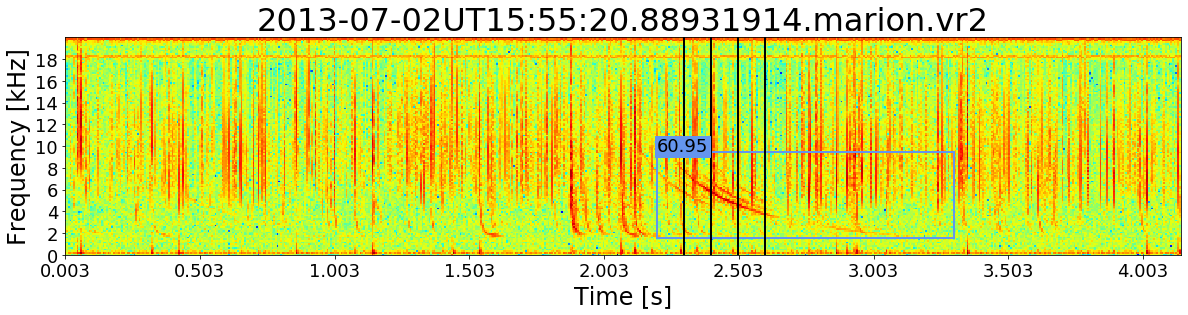

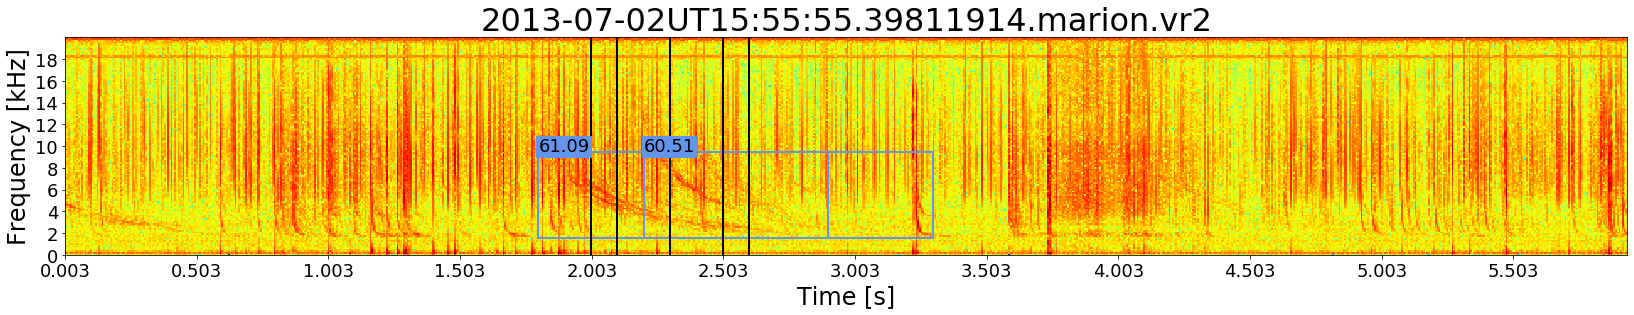

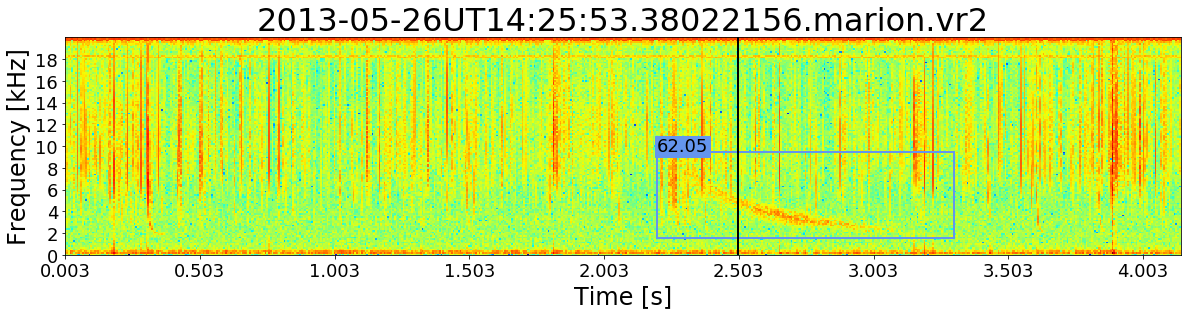

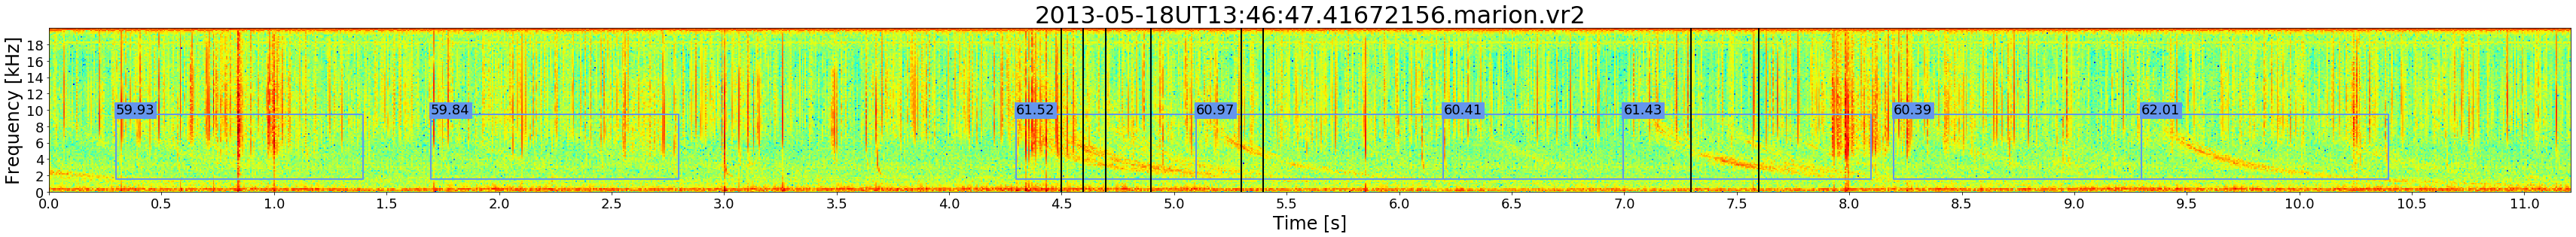

In [16]:
# CCSW
transforms, transforms_params = ['slice','zscore','scale'], [[1.5,9.5],[None],[0,1]]
N,G,k,Ts,Tl,X_dB = 12,10,13,5,3,0.5
pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
kernel = CFARDetector(dataset_loc, site, files[0]).load_kernel('sim', [0.35,80,1])
for file in files:
    sample = CFARDetector(dataset_loc, site, file)
    bboxes = sample.detection_bounding_boxes(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,Ts,Tl,pfa], threshold=0, time_err=1, duration=True)
#     print(bboxes)
    awd_output = [awd[0] for awd in sample.awda_whistlers(time_err=1)[0]]
    freq_size = 4
    sample = Sample(dataset_loc, site, file)
    sample.spectrogram_with_axis(log10=True)
    sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
    sample.spectrogram_plot(figsize=(sample.get_figsize()[0],4) , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                                       xaxis=True, yaxis=True,ticks=[0.5,2], title=file,cmap='jet', cmap_show=False, font=font,output=bboxes, vlines=awd_output)

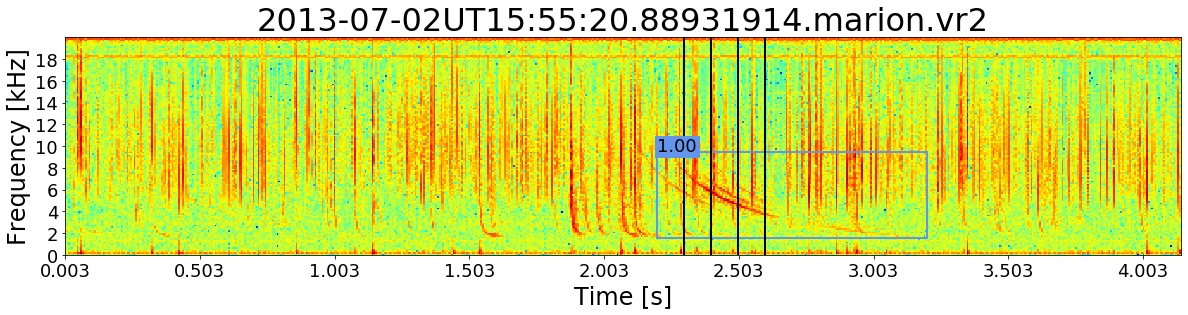

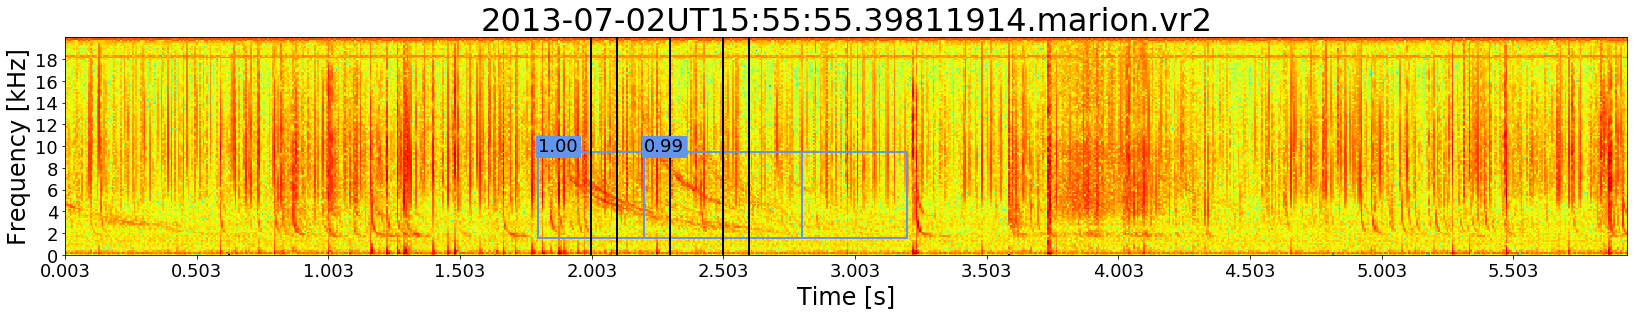

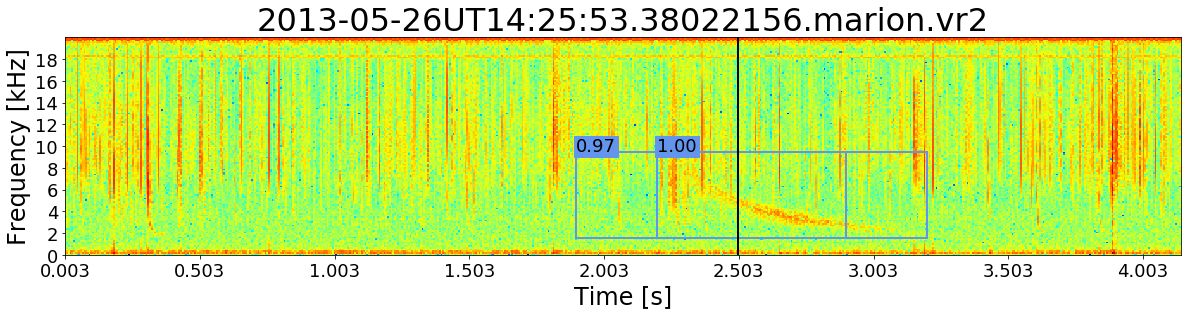

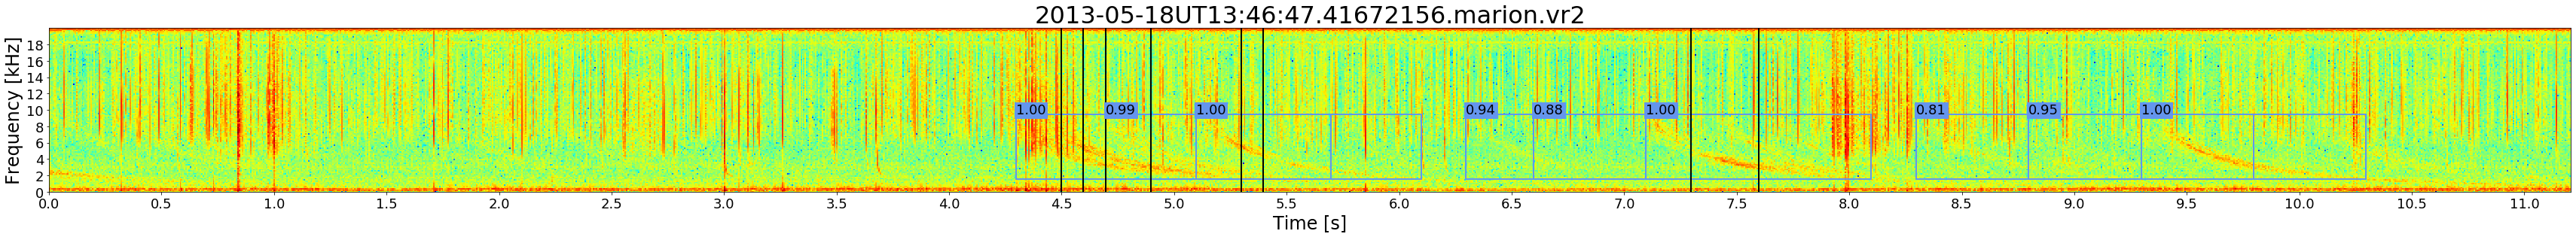

In [18]:
#SDCNN
transforms, transforms_params = 'zscore', None
name = 'cnn-3conv-2dense-4dropout-100epochs'
nn = NeuralNetworkDetector(dataset_loc, database_loc, site, transforms, transforms_params)
model = nn.load_model(name=name)
scaler = nn.load_scaler(name=name)
for file in files:
    sample = Sample(dataset_loc, site, file)
    bboxes = nn.detection_bounding_boxes(file,thresh=0.8, concav=True, concav_window=0.02,concav_error=-0.0, time_error=1)
    awd_output = [awd[0] for awd in sample.awda_whistlers(time_err=1)[0]]
    freq_size = 4
    sample.spectrogram_with_axis(log10=True)
    sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
    sample.spectrogram_plot(figsize=(sample.get_figsize()[0],4) , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                                       xaxis=True, yaxis=True,ticks=[0.5,2], title=file,cmap='jet', cmap_show=False, font=font,output=bboxes, vlines=awd_output)

[[1.    2.177 3.333 0.923 9.081]]


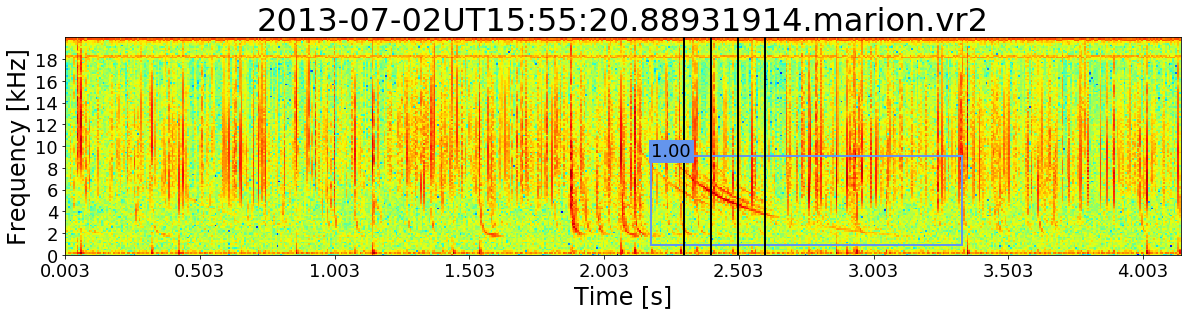

[[1.    1.872 2.857 1.165 9.689]
 [0.982 2.326 3.339 1.409 9.627]]


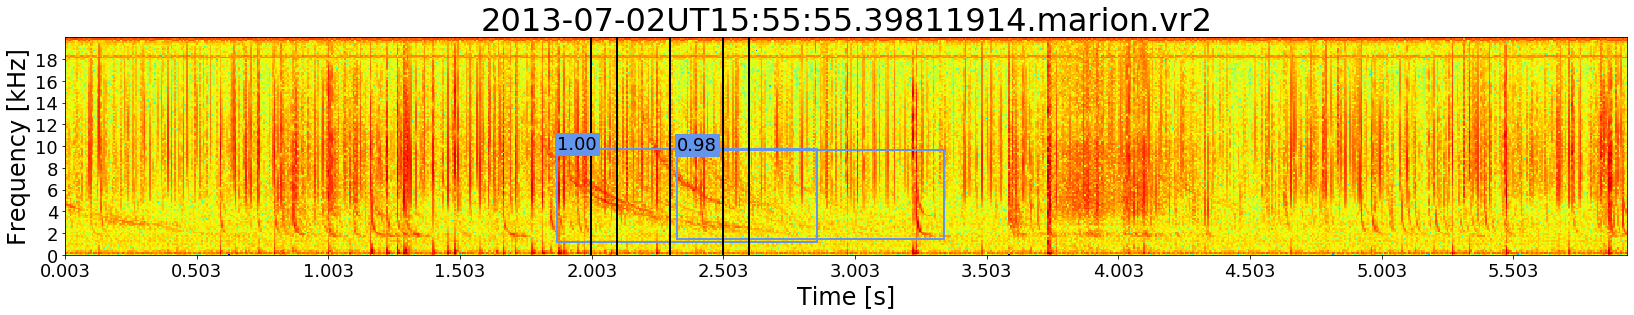

[[1.    2.186 3.374 1.482 9.349]]


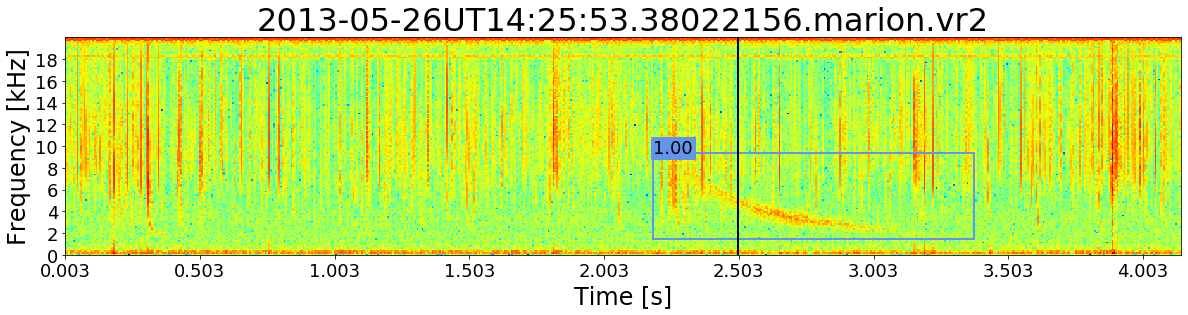

[[0.999 7.171 8.215 1.067 9.433]
 [0.996 4.36  5.616 0.632 9.365]
 [0.964 4.906 6.038 0.667 9.248]]


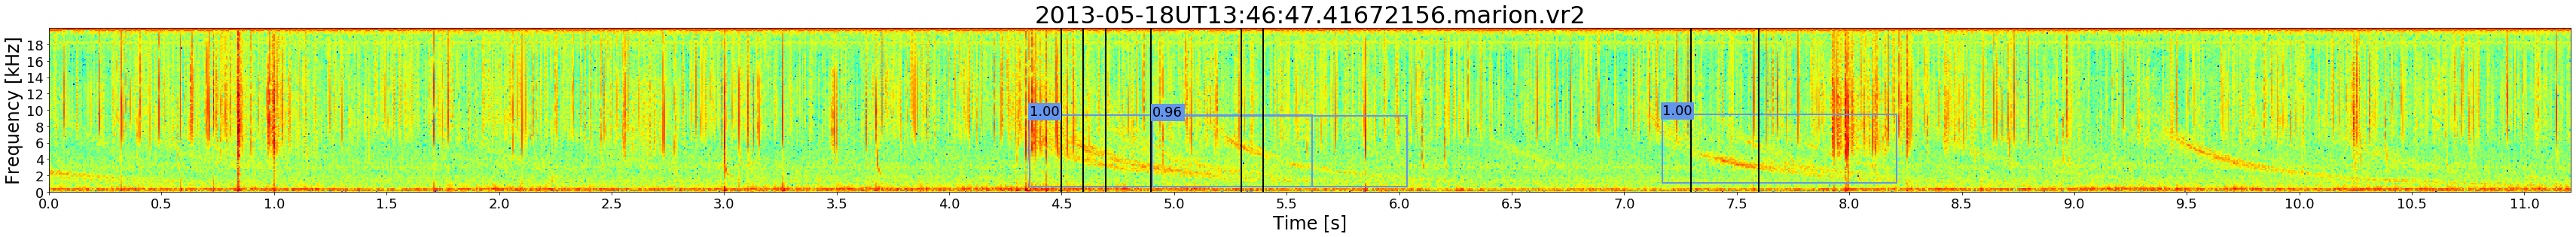

In [3]:
# YOLO
yolo = YOLODetector()
model_data_type = "real"
model_base = 'yolov3-tiny'
transforms, transforms_params = 'detrend', 'linear'
model_name = 'real_transfer_learning_detrend_linear'
yolo.load_model(model_base, model_data_type, model_name)
for file in files:
    sample = Sample(dataset_loc, site, file)
    bboxes = yolo.detection_bounding_boxes(dataset_loc, site, file, transforms, transforms_params,thresh=.8)
    print(bboxes)
    awd_output = [awd[0] for awd in sample.awda_whistlers(time_err=1)[0]]
    freq_size = 4
    sample.spectrogram_with_axis(log10=True)
    sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
    sample.spectrogram_plot(figsize=(sample.get_figsize()[0],4) , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                                       xaxis=True, yaxis=True,ticks=[0.5,2],title=file, cmap='jet', cmap_show=False, font=font,output=bboxes, vlines=awd_output)